## ASSIGNMENT-3

TEAM-NAME: Team Prestige

IDs: 2022702005,2022900038,2022701017

NAMEs: Amitabh Sharma, Saksham Gupta, Priyansh Sinha

### Instructions
 * Fill in the team name, id and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit this notebook in the GitHub Classroom repo and any other results files under the result folder. 
 * Commits past the deadline will not be considered.
 * Extensions will be granted using the extension policy only, so please go through the policy carefully and reach out to the TAs beforehand.
 * **Download the data for section 2 and 3 from this [link](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/pranjali_pathre_research_iiit_ac_in/Elm4OCxD4VhBh6f9x2ufKsgBnWwkmWc-nXPjnS5jXWRTww?e=IzOlbb)**.

In [80]:
# List the imports here
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import numpy.linalg as linalg
import random
import open3d as o3d

### SECTION 1: Epipolar lines and Epipoles

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix that encodes their relative geometry from these two images.

<img src="data/1/img1.jpg" alt="image 1" width="400"/>
<img src="data/1/img2.jpg" alt="image 2" width="400"/>

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions.

The point correspondences have been given in the folder `data/1`

In [81]:
# Helper Functions for Q1

def get_scaling_parameters(img1_pts , img2_pts  ):
    img1_pts_mean = np.mean(img1_pts, axis =0 )
    img2_pts_mean = np.mean(img2_pts, axis =0 )
    
    no_pts = np.shape(img1_pts)[0]
    
    factor1 =0 
    factor2 = 0
    
    for i in range(no_pts):
        factor1 += np.linalg.norm(img1_pts[i] - img1_pts_mean )**2
        factor2 += np.linalg.norm(img2_pts[i] - img2_pts_mean )**2
    
    val1 = 1.414 / (((1/no_pts)*factor1)**(1/2))
    val2 = 1.414 /(((1/no_pts)*factor2)**(1/2))
    
    pt1_matrix1 = np.array([[val1,  0  , 0],[ 0  , val1, 0],[ 0  ,   0 , 1]])
    
    pt2_matrix1 = np.array([[val2,  0  , 0],[  0 , val2, 0],[  0 ,  0  , 1]])   
    
    pt1_matrix2 = np.array([[  1 , 0 , -img1_pts_mean[0]  ]  ,[ 0, 1, -img1_pts_mean[1] ] ,[ 0 , 0 , 1 ]  ] )

    pt2_matrix2 = np.array([[  1 , 0 , -img2_pts_mean[0]  ]  , [ 0, 1, -img2_pts_mean[1] ] ,[ 0 , 0 , 1 ]  ] )
    
    T1 = pt1_matrix1@pt1_matrix2
    T2 = pt2_matrix1@pt2_matrix2
    
    return T1 , T2

def norm_coo(img1_pts ,img2_pts, T1,T2  ):
    
    norm_img1_pts = []
    norm_img2_pts = []
    
    no_pts = np.shape(img1_pts)[0]
    
    pt1 = np.ones( (3, 1) )
    pt2 = np.ones( (3, 1) )

    for i in range( no_pts ):
        
        pt1[0][0] = img1_pts[i][0]
        pt1[1][0] = img1_pts[i][1]
        
        pt2[0][0] = img2_pts[i][0]
        pt2[1][0] = img2_pts[i][1]
        
        P1  = T1@pt1 
        P2 = T2@pt2

        x1 = P1[0][0]
        y1 = P1[1][0]

        x2 = P2[0][0]
        y2 = P2[1][0]
               
        norm_img1_pts.append(  ( x1, y1 )  )
        norm_img2_pts.append( (x2, y2)  )
        
    return norm_img1_pts , norm_img2_pts

def get_kornecker_product( pt1s , pt2s ): 
    
    pt1_Homogeneous = np.ones( ( 3,1) )
    pt2_Homogeneous = np.ones( ( 3,1) )
    
    pt1_Homogeneous[0][0] = pt1s[0]
    pt1_Homogeneous[1][0] = pt1s[1]
    
    pt2_Homogeneous[0][0] = pt2s[0]
    pt2_Homogeneous[1][0] = pt2s[1]    
    
    A_row = np.kron(pt2_Homogeneous  , pt1_Homogeneous )
    
    return A_row.T

def get_a_matrix( norm_img1_pts , norm_img2_pts  ):
    
    no_pts = np.shape( norm_img1_pts)[0]
    A = np.zeros( ( no_pts , 9) )
    
    for i in range( no_pts ):
        A[ i , : ] = get_kornecker_product( norm_img1_pts[i] , norm_img2_pts[i]  )
    
    return A

def draw_line( img  , lines ,pts ):
    np.random.seed(3)
    n = img.shape[1]
    
    for r, pt1 in zip(lines, pts):
        
        pt1 = pt1.astype(np.int64)
        color = tuple(np.random.randint(0,255,3).tolist())
        x0 , y0 = map(int, [0, -r[2]/r[1] ])
        x1, y1 = map(int, [n, -(r[2]+r[0]*n)/r[1]])
        img = cv2.line(img, (x0,y0), (x1,y1),color,3)
              
        cv2.circle(img, tuple(pt1),8,color,10)
    return img

Fundamental Matrix:
 [[ 5.24856259e-07  1.39436611e-05 -9.71111715e-03]
 [-1.29089607e-05 -5.71276660e-08  5.97753350e-03]
 [ 6.95951561e-03 -6.18683310e-03  1.00000000e+00]]


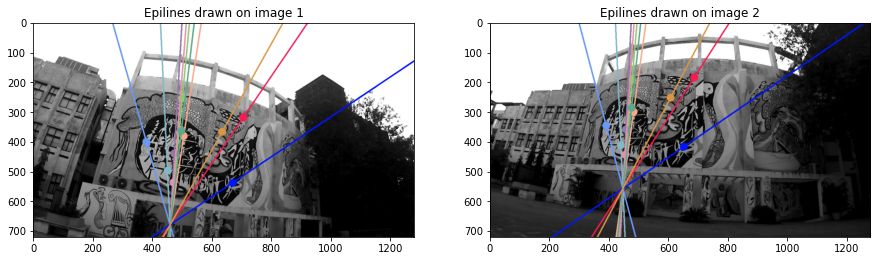

In [82]:
##############################################################################
# TODO: Do tasks described in 1
##############################################################################

img1 = cv2.imread('data/1/img1.jpg',0) # Given
img2 = cv2.imread('data/1/img2.jpg',0) # Given

img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

pts1 = [ [381, 402],[452 ,497],[671, 538],[501 ,254],[506 ,381],[474 ,440],[471, 537],[498 ,364],[706 ,319],[635 ,367] ] # Given
pts2 = [ [390, 346],[439 ,412],[651, 417],[477, 194],[482, 300],[456 ,359],[454 ,444],[475, 287],[686, 185],[606, 253] ] # Given

T1 , T2 = get_scaling_parameters(pts1 , pts2  )
Normalized_Image1_points , Normalized_Image2_points = norm_coo(pts1 ,pts2,T1,T2  )

A  = get_a_matrix(Normalized_Image1_points , Normalized_Image2_points  )
u, s, vt = np.linalg.svd( A )
V = vt[-1].reshape(( 3, 3 ))
F = np.reshape(V , ( 3, 3 ) )

u1, s1, vt1 = np.linalg.svd( F  )

s1[2] = 0
F = np.dot(u1, np.dot( np.diag(s1),vt1 ))

F = ((T2.T)@F@T1)
F = F/F[2, 2]

print("Fundamental Matrix:\n",F)

numPts = len(pts1)
start = 0 

Pt1x = []
Pt1y  =[]

Pt2x  = []
Pt2y = []

Pt1 = np.ones( ( numPts,3 ) )
Pt2 = np.ones( ( numPts,3 ) )

count = 0 
for i in range(start , start +numPts ):

    Pt1[count][0] = pts1[i][0]
    Pt1[count][1] = pts1[i][1]
    
    Pt2[count][0] = pts2[i][0]
    Pt2[count][1] = pts2[i][1]
    
    count +=1

lines1 = (F@Pt1.T).T
lines2 = (F.T@Pt2.T).T

img1_epilines = draw_line(img1,lines2,Pt1[:, 0:2] )
img2_epilines = draw_line(img2,lines1,Pt2[:, 0:2] )
    
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].imshow(img1_epilines)
ax[0].title.set_text('Epilines drawn on image 1')
ax[1].imshow(img2_epilines)
ax[1].title.set_text('Epilines drawn on image 2')

##############################################################################
# END OF YOUR CODE
##############################################################################

### SECTION 2: Visual Odometry

Visual odometry is the process of recovering the egomotion (the trajectory) of an agent using only the input from the camera or a system of cameras attached to the agent. This is a well-
studied problem in robotic vision and is a critical part of many applications such as mars rovers, and self-driving cars for localization. You will be implementing a basic monocular visual odometry algorithm in this part of the assignment.

To begin with, download all the required data from `data/2`. It contains a sequence of images from the KITTI dataset. The ground truth pose of each frame (in row-major order) and the camera parameters are provided as well.

#### Procedure
The following is an overview of the entire algorithm. 
1. Find the corresponding features between frames $I_{k}$ and $I_{k-1}$.
2. Using these features correspondances, estimate the essential matrix between the two images within a RANSAC sceme.
3. Decompose the essential matrix to obtain the relative rotation $R_k$ and transition $t_k$, and form the transformation $T_k$.
4. Scale the translation $t_k$ with the absolute or the relative scale. 
5. Concatenate the relative transformation by computing $C_k$ = $C_{k-1}$ $T_k$, where $C_{k-1}$ is the previous pose of the camera in the world frame. 
6. Repeat the above steps for the remaining pairs of frames.

The main task in computing visual odometry is to compute the relative transformation $T_k$ from each pair of images $I_k$ and $I_{k-1}$ and then to concatenate these transformations to recover the full trajectory of the camera. There are two broad approaches to compute the relative motion $T_k$: Appearance-based (or direct) method, which uses the intensity information of all the pixels in the input images and feature-based method which only uses salient and repeatable features extracted and tracked across the images. You will be implementing a feature-based method. 

For every new image $I_k$, the first step consists of detecting and matching 2D features with those from the previous frame. These 2D features are the locations in the image which we can reliably find in multiple images and possibly match them. To find these features use the inbuilt SIFT OpenCV implementation. 

Refer to [OpenCV documentation](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html) for the impementation details. 

As mentioned earlier, the main task is motion computation. Using these feature correspondences, implement the 8-point algorithm for fundamental matrix estimation. Implement it inside a RANSAC scheme to get rid of any outliers, as explained in class. Then, compute the essential matrix, and decompose it to the relative R and t using ```cv2.recoverPose```. Note that the function returns the R and t of the first camera with respect to the second, and not the other way around.

Now, you might recall that the absolute scale of the translation cannot be computed from just two images. The above function only returns the direction of t, as a unit vector. Use the ground truth translation to get the absolute scale, and multiply your unit translation with this scale. Then concatenate your transformations, and repeat for the next pair of frames to recover the full absolute trajector

Deliverables:
* A .txt file containing the estimated poses, provided in the same format as the ground truth.
* A plot of the estimated trajectory along with the ground truth trajectory. Also report the obtained trajectory error. Use [EVO](https://github.com/MichaelGrupp/evo) for this.
```
pip install evo --upgrade --no-binary evo
evo_traj kitti ground-truth.txt your-result.txt -va --plot --plot_mode xz
```
* Comment on the performance of your algorithm. When does it work well or it fails and why?

In [13]:
# evo_ape kitti ground-truth.txt results.txt -va --plot --plot_mode xz

def get_fundamental(src, dst):
    A = np.zeros((8, 9))
    for i in range(8):
        A[i] = [src[i][0] * dst[i][0], src[i][0] * dst[i][1], src[i][0],src[i][1] * dst[i][0], src[i][1] * dst[i][1], src[i][1],dst[i][0], dst[i][1], 1]
    B = np.matmul(A.transpose(), A)
    eigen_vals, eigen_vecs = linalg.eig(B)
    idx = eigen_vals.argsort()[::-1]   
    eigen_vals = eigen_vals[idx]
    eigen_vecs = eigen_vecs[:,idx]
    temp = eigen_vecs[1]
    F = np.array([[temp[0], temp[1], temp[2]],[temp[3], temp[4], temp[5]],[temp[6], temp[7], temp[8]]])
    return np.real(F)

def ransac(s, d):
    minval = 9999999
    hold = None
    for i in range(800):
        c = [random.randint(0, len(s)-1) for x in range(8)]
        sin = [s[x] for x in c]
        din = [d[x] for x in c]
        temp = get_fundamental(sin, din)
        t = 0
        for j in range(len(s)):
            v1 = np.transpose(np.array([d[j][0], d[j][1], 1]))
            v2 = np.array([s[j][0], s[j][1], 1])
            temp2 = np.matmul(v1, temp)
            t += np.matmul(temp2, v2)
        if t < 0:
            t = -1 * t
        if t < minval:
            hold = temp
            minval = t
    return hold

def scalling(pose, index):
    p = pose[index - 1].strip().split()
    x_prev = float(p[3])
    y_prev = float(p[7])
    z_prev = float(p[11])
    p = pose[index].strip().split()
    x = float(p[3])
    y = float(p[7])
    z = float(p[11])
    true_vect = np.array([[x], [y], [z]])
    prev_vect = np.array([[x_prev], [y_prev], [z_prev]])
    return np.linalg.norm(true_vect - prev_vect)

In [14]:
im_dir = os.listdir('./data/2/images')
im_dir.sort()
images = [cv2.imread(os.path.join('./data/2/images/', x)) for x in im_dir]
features = []
sift = cv2.xfeatures2d.SIFT_create()

K = np.array([[7.215377000000e+02,0.000000000000e+00,6.095593000000e+02],
              [0.000000000000e+00,7.215377000000e+02,1.728540000000e+02],
              [0.000000000000e+00,0.000000000000e+00,1.000000000000e+00]])

for i in images:
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY), None)
    features.append({"kp": kp1, "des": des1})

def main():
    R_prev = np.eye(3)
    T_prev = np.zeros((3, 1))
                       
    with open('./data/2/ground-truth.txt') as f:
        pose_c = f.readlines()
    sf = ''
    for i in range(1, len(images)):
        bf = cv2.BFMatcher()     
        matches = bf.knnMatch(features[i-1]['des'], features[i]['des'], k=2)
        good = []
        for m in matches:
            if m[0].distance < 0.15*m[1].distance:
                good.append(m)
        if len(good) > 10:
            matches = np.asarray(good)
        else:
            matches = np.asarray(matches)
        if len(matches[:,0]) >= 8:
            src = np.float32([ features[i-1]['kp'][m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
            dst = np.float32([ features[i]['kp'][m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        src_new = []
        dst_new = []
        for o in range(len(src)):
            src_new.append(src[o][0])
            dst_new.append(dst[o][0])
        src = np.array(src_new)
        dst = np.array(dst_new)
        F = ransac(src, dst)
        E = np.matmul(np.matmul(K.T, F), K)
        _, R, t, mask = cv2.recoverPose(E, src, dst)
        if i <= 2:
            R_prev = R
            abs_scale = scalling(pose_c, i)
            T_prev = t * abs_scale
        else:
            abs_scale = scalling(pose_c, i)
            T_prev = T_prev + np.linalg.inv(R).dot(t) * abs_scale 
            R_prev = R.dot(R_prev)
        print(i)
        for x in np.concatenate([R_prev, T_prev], axis=1):
            for y in x:
                sf += str("{:.6e}".format(float(y))) + ' '
        sf = sf[:-1]
        sf += '\n'
    f = open('results.txt', 'w')
    f.write(sf)
main()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


A monocular visual odometry algorithm estimates the motion of a camera by analyzing consecutive images taken from a single camera.

It works well when:
1) Good features are selected
2) Sufficient textures and structures are present
3) Consistent lighting conditions
4) Limited camera motion

It fails when:
1) Fast or erratic motion
2) Dynamic environments
3) Camera calibration and distortion
4) Lack of features or ambiguous features
5) Poor lighting or illumination changes

### SECTION 3: Stereo Dense Reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo cameras provide  us  with  a  convenient  way  to  generate  dense  point  clouds. Dense here,  in  contrast  to sparse, means all the image points are used for the reconstruction.  In this part of the assignment you will be generating a dense 3D point cloud reconstruction of a scene from stereo images. Refer `data/3` folder. It contains `img2` and `img3` folder for left and right stereo images respectively. `poses.txt` contains flatten 12 values of transformation matrix for each pose and `calib.txt` contains `K & Baseline`.

#### Procedure

1. Generate a disparity map for all given stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Note that the images provided are already rectified and undistorted.
2. Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them. Use `Open3D` for storing your point clouds.
3. Register (or transform) all the generated point clouds into your world frame by using the provided ground truth poses.
4. Visualize the registered point cloud data, in color.  Use Open3D for this.

    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [49]:
pose = np.array([
    np.array([[-9.098548e-01,5.445376e-02,-4.113381e-01,-1.872835e+02],[4.117828e-02,9.983072e-01,4.107410e-02,1.870218e+00],[4.128785e-01,2.043327e-02,-9.105569e-01,5.417085e+01],[0,0,0,1]]),
    np.array([[-9.283201e-01,4.509830e-02,-3.690366e-01,-1.874227e+02],[3.357747e-02,9.987291e-01,3.758534e-02,1.883289e+00],[3.702626e-01,2.249990e-02,-9.286546e-01,5.369416e+01],[0,0,0,1]]),
    np.array([[-9.452512e-01,3.706129e-02,-3.242324e-01,-1.875256e+02],[2.776133e-02,9.990610e-01,3.326342e-02,1.887417e+00],[3.251607e-01,2.244117e-02,-9.453925e-01,5.321309e+01],[0,0,0,1]]),
    np.array([[-9.602059e-01,3.410654e-02,-2.772028e-01,-1.876307e+02],[2.674480e-02,9.991831e-01,3.029615e-02,1.893359e+00],[2.780097e-01,2.167680e-02,-9.603337e-01,5.273710e+01],[0,0,0,1]]),
    np.array([[-9.729422e-01,3.276894e-02,-2.287129e-01,-1.876915e+02],[2.667847e-02,9.992036e-01,2.967147e-02,1.900316e+00],[2.295031e-01,2.276691e-02,-9.730416e-01,5.225276e+01],[0,0,0,1]]),
    np.array([[-9.831529e-01,3.240420e-02,-1.798899e-01,-1.877485e+02],[2.738709e-02,9.991654e-01,3.030454e-02,1.901338e+00],[1.807218e-01,2.486734e-02,-9.832198e-01,5.177232e+01],[0,0,0,1]]),
    np.array([[-9.911510e-01,2.523874e-02,-1.303180e-01,-1.877723e+02],[2.111370e-02,9.992343e-01,3.293915e-02,1.900778e+00],[1.310496e-01,2.989617e-02,-9.909249e-01,5.129098e+01],[0,0,0,1]]),
    np.array([[-9.966637e-01,1.446740e-02,-8.032513e-02,-1.877414e+02],[1.146235e-02,9.992216e-01,3.774707e-02,1.901606e+00],[8.080871e-02,3.670042e-02,-9.960537e-01,5.080341e+01],[0,0,0,1]]),
    np.array([[-9.995040e-01,1.006074e-02,-2.984320e-02,-1.877165e+02],[8.815319e-03,9.990965e-01,4.157437e-02,1.903912e+00],[3.023451e-02,4.129067e-02,-9.986896e-01,5.033042e+01],[0,0,0,1]]),
    np.array([[-9.996705e-01,1.307490e-02,2.209183e-02,-1.876828e+02],[1.395603e-02,9.990937e-01,4.021250e-02,1.909578e+00],[-2.154603e-02,4.050756e-02,-9.989469e-01,4.986716e+01],[0,0,0,1]]),
    np.array([[-9.970705e-01,2.051987e-02,7.368440e-02,-1.876045e+02],[2.335961e-02,9.990090e-01,3.788635e-02,1.913879e+00],[-7.283396e-02,3.949659e-02,-9.965617e-01,4.940375e+01],[0,0,0,1]]),
    np.array([[-9.919546e-01,2.316199e-02,1.244574e-01,-1.875198e+02],[2.767742e-02,9.990153e-01,3.467489e-02,1.916071e+00],[-1.235318e-01,3.784057e-02,-9.916189e-01,4.895472e+01],[0,0,0,1]]),
    np.array([[-9.843986e-01,2.362611e-02,1.743596e-01,-1.873856e+02],[2.975169e-02,9.990255e-01,3.260177e-02,1.916040e+00],[-1.734194e-01,3.728062e-02,-9.841422e-01,4.850872e+01],[0,0,0,1]]),
    np.array([[-9.745046e-01,2.207656e-02,2.232787e-01,-1.872454e+02],[2.939030e-02,9.991330e-01,2.948581e-02,1.919502e+00],[-2.224342e-01,3.529628e-02,-9.743086e-01,4.808322e+01],[0,0,0,1]]),
    np.array([[-9.620042e-01,2.331542e-02,2.720374e-01,-1.870919e+02],[3.162970e-02,9.991557e-01,2.621754e-02,1.921924e+00],[-2.711965e-01,3.382584e-02,-9.619295e-01,4.766758e+01],[0,0,0,1]]),
    np.array([[-9.466844e-01,2.747540e-02,3.209888e-01,-1.869050e+02],[3.735473e-02,9.989978e-01,2.465901e-02,1.925132e+00],[-3.199896e-01,3.533474e-02,-9.467619e-01,4.724980e+01],[0,0,0,1]]),
    np.array([[-9.303521e-01,3.021656e-02,3.654203e-01,-1.867142e+02],[4.116827e-02,9.989052e-01,2.221412e-02,1.922721e+00],[-3.643491e-01,3.571067e-02,-9.305775e-01,4.684089e+01],[0,0,0,1]]),
    np.array([[-9.132370e-01,2.475193e-02,4.066762e-01,-1.864782e+02],[3.739334e-02,9.990320e-01,2.316585e-02,1.917552e+00],[-4.057092e-01,3.636289e-02,-9.132786e-01,4.643056e+01],[0,0,0,1]]),
    np.array([[-8.953418e-01,1.994046e-02,4.449332e-01,-1.862433e+02],[3.564541e-02,9.990008e-01,2.695748e-02,1.910636e+00],[-4.439511e-01,3.999598e-02,-8.951580e-01,4.602498e+01],[0,0,0,1]]),
    np.array([[-8.776813e-01,1.983338e-02,4.788341e-01,-1.859999e+02],[3.901401e-02,9.987839e-01,3.014110e-02,1.906858e+00],[-4.776541e-01,4.513551e-02,-8.773878e-01,4.562057e+01],[0,0,0,1]]),
    np.array([[-8.608718e-01,2.164481e-02,5.083614e-01,-1.857437e+02],[4.407236e-02,9.985119e-01,3.211896e-02,1.904895e+00],[-5.069097e-01,5.005498e-02,-8.605447e-01,4.521752e+01],[0,0,0,1]])
])

tempp = os.listdir('./data/3/img2')
temppp = os.listdir('./data/3/img3')
imgs_left = sorted(tempp)
imgs_right = sorted(temppp)

K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
              [0.000000e+00 ,7.070912e+02, 1.831104e+02],
              [0.000000e+00 ,0.000000e+00, 1.000000e+00] ])

focal_length = 7.070912e+02
baseline = 0.53790448812

FX_DEPTH = K[0,0]
FY_DEPTH = K[1,1]
CX_DEPTH = K[0,2]
CY_DEPTH = K[1,2]
print(FX_DEPTH,FY_DEPTH,CX_DEPTH,CY_DEPTH)

print(len(imgs_left),len(imgs_right))
print(imgs_left)
print(imgs_right)

707.0912 707.0912 601.8873 183.1104
21 21
['0000000460.png', '0000000461.png', '0000000462.png', '0000000463.png', '0000000464.png', '0000000465.png', '0000000466.png', '0000000467.png', '0000000468.png', '0000000469.png', '0000000470.png', '0000000471.png', '0000000472.png', '0000000473.png', '0000000474.png', '0000000475.png', '0000000476.png', '0000000477.png', '0000000478.png', '0000000479.png', '0000000480.png']
['0000000460.png', '0000000461.png', '0000000462.png', '0000000463.png', '0000000464.png', '0000000465.png', '0000000466.png', '0000000467.png', '0000000468.png', '0000000469.png', '0000000470.png', '0000000471.png', '0000000472.png', '0000000473.png', '0000000474.png', '0000000475.png', '0000000476.png', '0000000477.png', '0000000478.png', '0000000479.png', '0000000480.png']


In [78]:
combined_pcd = np.array([[0,0,0]])
combined_pcd_colors = np.array([[0,0,0]])

for k in range(0,len(imgs_left)):
    frame_l = cv2.imread('./data/3/img2/'+imgs_left[k])
    frame_r = cv2.imread('./data/3/img3/'+imgs_left[k])

    left = cv2.cvtColor(frame_l, cv2.COLOR_BGR2GRAY)
    right = cv2.cvtColor(frame_r, cv2.COLOR_BGR2GRAY)

    win=7 
    stereo = cv2.StereoSGBM_create(minDisparity = 16,
       numDisparities = 128,
       blockSize = 7,
       disp12MaxDiff = 1,
       speckleWindowSize = 100,
       speckleRange = 32,
       uniquenessRatio = 10,
       P1 = 8*3*win*7,
       P2 = 32*3*win*7,
    )
    
    disparitymap = stereo.compute(left, right).astype(np.float32) / 16.0 

    pcdd = []
    colors=[]
    height, width = disparitymap.shape
    for i in range(height):
        for j in range(width):
            if disparitymap[i][j] !=  0:
                depth = baseline*focal_length/disparitymap[i][j]
                z = depth 
                x = ((j - CX_DEPTH) * z / FX_DEPTH) 
                y = ((i - CY_DEPTH) * z / FY_DEPTH)
                if not(np.isinf(x)) and not(np.isinf(y)) and not(np.isinf(z)): 
                    pcdd.append([x, y, z])
                    colors.append([ frame_l[i][j][2]/255,frame_l[i][j][1]/255,frame_l[i][j][0]/255 ])
    
    out_points = np.array(pcdd)
    out_colors = np.array(colors)

    T = pose[k]
    print(k)

    temp = np.ones((out_points.shape[0],1))
    pointss = np.append(out_points,temp,axis=1)
    out_points = np.dot(T,pointss.T).T[:,(0,1,2)]

    combined_pcd =  np.vstack((combined_pcd,np.asarray(out_points)))
    combined_pcd_colors =  np.vstack((combined_pcd_colors,np.asarray(out_colors)))


combined_pcd[:,0] = -combined_pcd[:,0]
combined_pcd[:,1] = -combined_pcd[:,1]
# combined_pcd[:,0] = -combined_pcd[:,0]


pcddd = o3d.geometry.PointCloud()
pcddd.points = o3d.utility.Vector3dVector(combined_pcd[1:])
pcddd.colors = o3d.utility.Vector3dVector(combined_pcd_colors[1:])

o3d.visualization.draw_geometries([pcddd])
o3d.io.write_point_cloud(f'./Output Q3/Q3_final_point_cloud.pcd', pcddd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


True

In [79]:
pcd = o3d.io.read_point_cloud(f'./Output Q3/Q3_final_point_cloud.pcd')
o3d.visualization.draw_geometries([pcd])

Overview of the process of generating a disparity map using OpenCV's SGBM algorithm:

1) Rectification: 
    Before generating the disparity map, stereo images need to be rectified to ensure that corresponding points lie on the same scanlines.
    The images provided have already been rectified.

2) Matching Cost Calculation: 
    SGBM algorithm works by computing the matching cost for each pixel in the left image against a set of pixels in the right image within a specified window.

3) Cost Aggregation: 
    After calculating the matching costs, a cost aggregation step is performed to combine neighboring pixels' costs, usually using techniques like semi-global or global methods to refine the disparity estimates.

4) Disparity Computation: 
    Using the aggregated cost volumes, the disparity values for each pixel in the left image are computed.

In [1]:
# output file for Q3 Google drive link:
#  https://drive.google.com/drive/folders/1Asbupa4lNyz-Kswac5sndqfs4GzuwAmK?usp=sharing